In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib as plt
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import _LRScheduler
from PIL import Image
from scipy.ndimage import map_coordinates, gaussian_filter
from sklearn.metrics import precision_recall_fscore_support
import shutil

%run '/kaggle/input/icdar19-wsegs-cte-dataloader/CTE.ipynb'
%run '/kaggle/input/icdar19-wsegs-cte-dataloader/dataloader_ICDAR19_lsegs.ipynb'


import numpy as np
import os

torch.Size([1, 105])


In [2]:
class LabelSomCE(nn.Module):
	def __init__(self):
		super().__init__()

	def forward(self,x,target,smoothing=0.1):
		confidence = 1.0 - smoothing
		logprobs = F.log_softmax(x,dim=-1)
		nll_loss = - logprobs.gather(dim=-1,index=target.unsqueeze(1))
		nll_loss = nll_loss.squeeze(1)
		smooth_loss = -logprobs.mean(dim=-1)
		loss = confidence * nll_loss + smoothing * smooth_loss

		return loss.mean()

def download(folder,thetarfile):
    import urllib.request
    import tarfile
    ftpstream = urllib.request.urlopen(thetarfile)
    thetarfile = tarfile.open(fileobj=ftpstream, mode="r|gz")
    thetarfile.extractall(folder)
    thetarfile.close()

def download_cerug(folder):
    thetarfile = "https://www.ai.rug.nl/~sheng/writerset/CERUG-EN-train-images.tar.gz"
    download(folder,thetarfile)
    thetarfile = "https://www.ai.rug.nl/~sheng/writerset/CERUG-EN-test-images.tar.gz"
    download(folder,thetarfile)

def download_firemaker(folder):
    thetarfile = "https://www.ai.rug.nl/~sheng/writerset/Firemaker-train-images.tar.gz"
    download(folder,thetarfile)
    thetarfile = "https://www.ai.rug.nl/~sheng/writerset/Firemaker-test-images.tar.gz"
    download(folder,thetarfile)

    
def copy_folder_contents(source_folder, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    for item in os.listdir(source_folder):
        source_path = os.path.join(source_folder, item)
        destination_path = os.path.join(destination_folder, item)
        if os.path.isdir(source_path):
            shutil.copytree(source_path, destination_path)
        else:
            shutil.copy2(source_path, destination_path)

In [3]:
class ImageTransformer:
    def __init__(self, foldername, imgtype='png'):
        self.imgtype = imgtype
        self.folder = foldername
        self.imglist = self.get_imgList(self.folder)
        #print(f'Image list: {self.imglist}')
        print(f'Number of images: {len(self.imglist)}')

    def get_imgList(self, folder):
        return [img for img in os.listdir(folder) if img.endswith(self.imgtype)]

    def elastic_transform(self, image, alpha, sigma):
        random_state = np.random.RandomState(None)
        shape = image.shape

        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

        x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
        indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))

        distorted_image = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
        return distorted_image

    def perspective_transform(self, image):
        width, height = image.size
        coeffs = self.find_coeffs(
            [(0, 0), (width, 0), (width, height), (0, height)],
            [(random.randint(0, width // 4), random.randint(0, height // 4)),
             (width - random.randint(0, width // 4), random.randint(0, height // 4)),
             (width - random.randint(0, width // 4), height - random.randint(0, height // 4)),
             (random.randint(0, width // 4), height - random.randint(0, height // 4))]
        )
        return image.transform((width, height), Image.PERSPECTIVE, coeffs, Image.BICUBIC)

    def zoom_out_transform(self, image, scale=0.8):
        width, height = image.size
        new_width, new_height = int(width * scale), int(height * scale)
        return image.resize((new_width, new_height), Image.BICUBIC)

    def find_coeffs(self, pa, pb):
        matrix = []
        for p1, p2 in zip(pa, pb):
            matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0] * p1[0], -p2[0] * p1[1]])
            matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1] * p1[0], -p2[1] * p1[1]])

        A = np.matrix(matrix, dtype=float)
        B = np.array(pb).reshape(8)

        res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
        return np.array(res).reshape(8)

    def process_and_save_images(self):
        for imgfile in self.imglist:
            # Open the image
            image = Image.open(os.path.join(self.folder, imgfile)).convert('L')
            original_image = np.array(image)

            # Save original image
            original_image_filename = os.path.join(self.folder, imgfile)
            image.save(original_image_filename)

            # Elastic distortion
            elastic_image = self.elastic_transform(original_image, alpha=34, sigma=4)
            elastic_image = Image.fromarray(elastic_image).convert('L')
            elastic_image_filename = os.path.join(self.folder, imgfile.split('.')[0] + '_1.' + self.imgtype)
            elastic_image.save(elastic_image_filename)

            # Perspective transformation
            perspective_image = self.perspective_transform(image)
            perspective_image_filename = os.path.join(self.folder, imgfile.split('.')[0] + '_2.' + self.imgtype)
            perspective_image.save(perspective_image_filename)

            # Zoom out transformation
            zoom_out_image = self.zoom_out_transform(image, scale=0.8)  # Adjust scale as needed
            zoom_out_image_filename = os.path.join(self.folder, imgfile.split('.')[0] + '_3.' + self.imgtype)
            zoom_out_image.save(zoom_out_image_filename)

Number of images: 22839
ICDAR19_wsegsICDAR19_wsegswriter_index_table.pickle
----------
loading dataset /kaggle/input/firemaker-words/Firemaker Dataset with images: 91356
number of writer is: 250
-*-*-*-*-*-*-*-*-*-*
ICDAR19_wsegsICDAR19_wsegswriter_index_table.pickle
----------
loading dataset /kaggle/input/firemaker-words/Firemaker Dataset with images: 2417
number of writer is: 250
-*-*-*-*-*-*-*-*-*-*
Traing epoch: 0   avg loss is: 5.9671992227020105
Validation epoch: 0   avg validation loss is: 3.746907541626378
Validating on epoch: 0 has accuracy: top1: 25.03 top5: 53.95


/tmp/ipykernel_24/2464112475.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Validating on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2464112475.py:156: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Validating epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


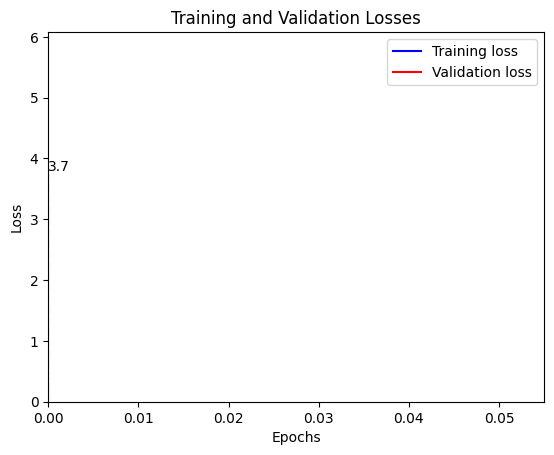

Traing epoch: 1   avg loss is: 3.4848625129566737
Validation epoch: 1   avg validation loss is: 2.989092723319405
Validating on epoch: 1 has accuracy: top1: 44.56 top5: 73.85


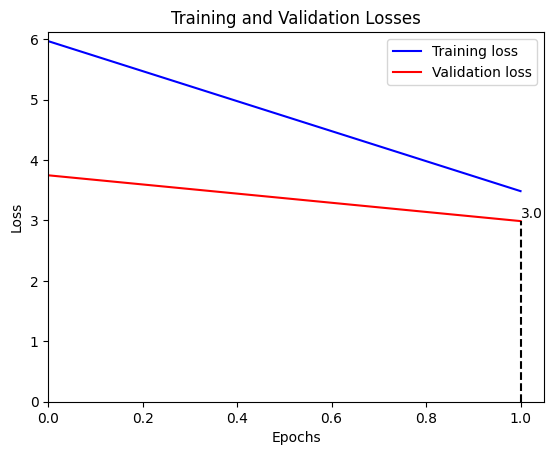

Traing epoch: 2   avg loss is: 2.830942620932899
Validation epoch: 2   avg validation loss is: 2.5301270006518615
Validating on epoch: 2 has accuracy: top1: 57.51 top5: 84.61


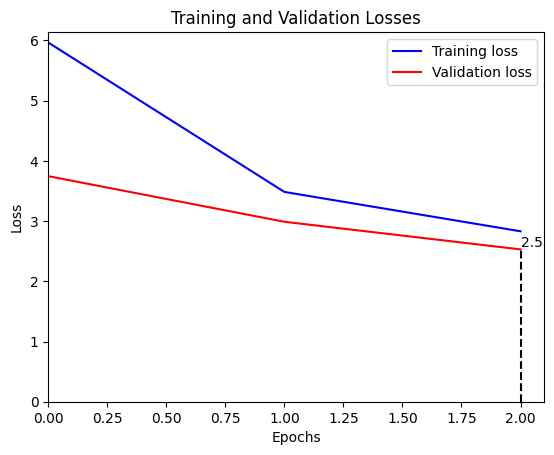

Traing epoch: 3   avg loss is: 2.452873865888632
Validation epoch: 3   avg validation loss is: 2.3033736206983266
Validating on epoch: 3 has accuracy: top1: 65.12 top5: 87.79


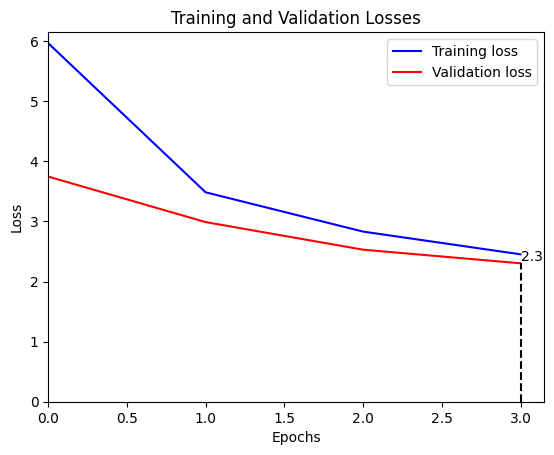

Traing epoch: 4   avg loss is: 2.190809483347726
Validation epoch: 4   avg validation loss is: 2.1617527564889505
Validating on epoch: 4 has accuracy: top1: 69.42 top5: 88.75


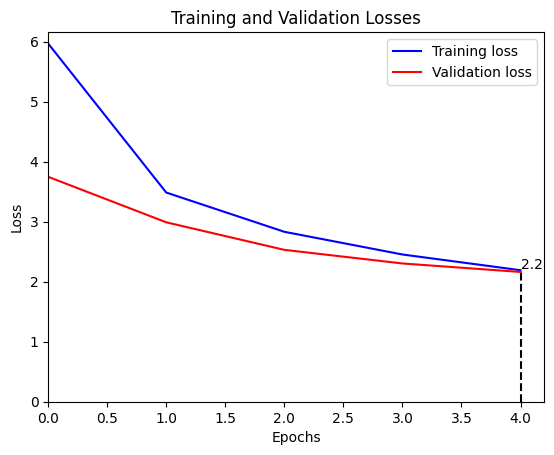

Traing epoch: 5   avg loss is: 1.991506556095645
Validation epoch: 5   avg validation loss is: 2.1549496282088128
Validating on epoch: 5 has accuracy: top1: 68.80 top5: 88.99


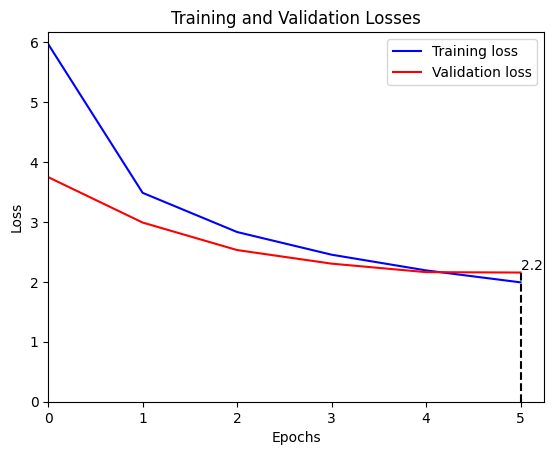

Traing epoch: 6   avg loss is: 1.8246575354235166
Validation epoch: 6   avg validation loss is: 2.1537726717559913
Validating on epoch: 6 has accuracy: top1: 68.02 top5: 89.62


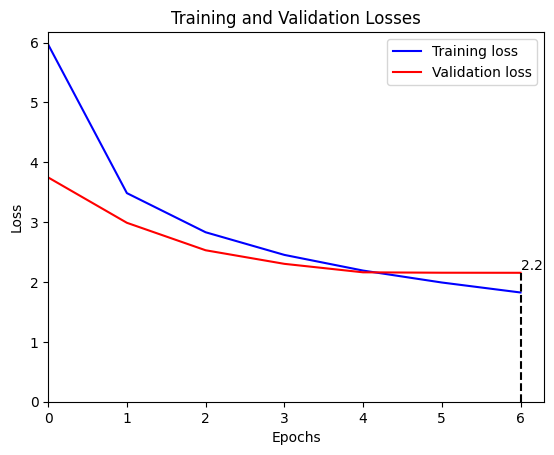

Traing epoch: 7   avg loss is: 1.6928284934156308
Validation epoch: 7   avg validation loss is: 2.1200479496466484
Validating on epoch: 7 has accuracy: top1: 71.12 top5: 89.53


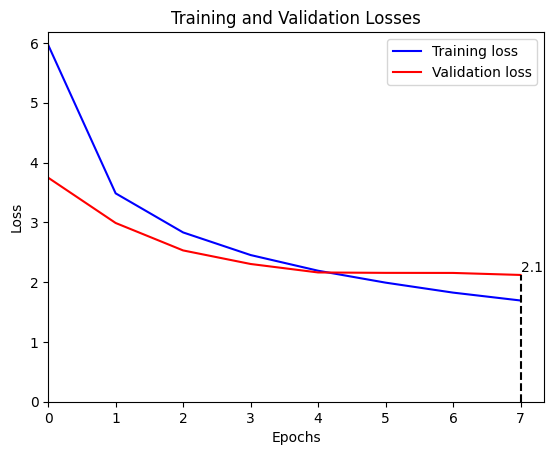

Traing epoch: 8   avg loss is: 1.5854192501526827
Validation epoch: 8   avg validation loss is: 2.0059909067655863
Validating on epoch: 8 has accuracy: top1: 73.89 top5: 90.69


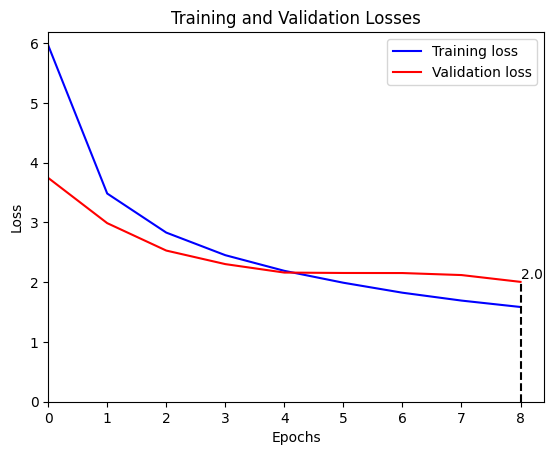

Traing epoch: 9   avg loss is: 1.500625155731725
Validation epoch: 9   avg validation loss is: 2.0073273252499733
Validating on epoch: 9 has accuracy: top1: 73.44 top5: 90.82


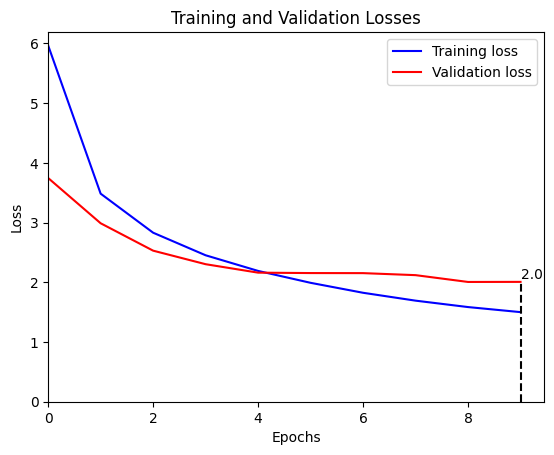

Traing epoch: 10   avg loss is: 1.2786909171632468
Validation epoch: 10   avg validation loss is: 1.7124379551724385
Validating on epoch: 10 has accuracy: top1: 82.79 top5: 93.55


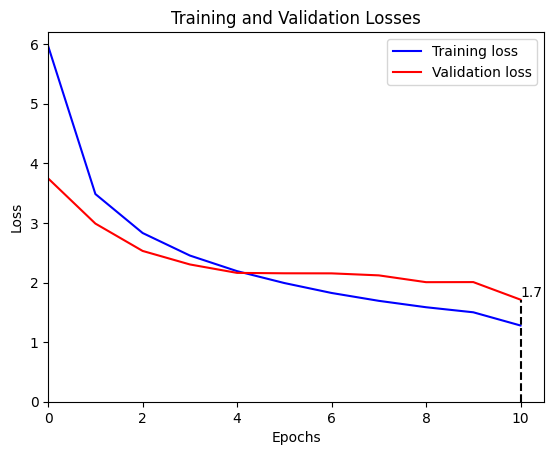

Traing epoch: 11   avg loss is: 1.2264814092641454
Validation epoch: 11   avg validation loss is: 1.8550172165820473
Validating on epoch: 11 has accuracy: top1: 77.00 top5: 92.68


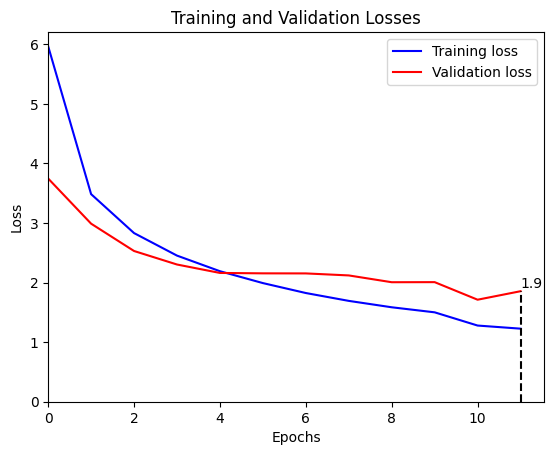

Traing epoch: 12   avg loss is: 1.1920971127687308
Validation epoch: 12   avg validation loss is: 1.8124060113179057
Validating on epoch: 12 has accuracy: top1: 79.44 top5: 92.93


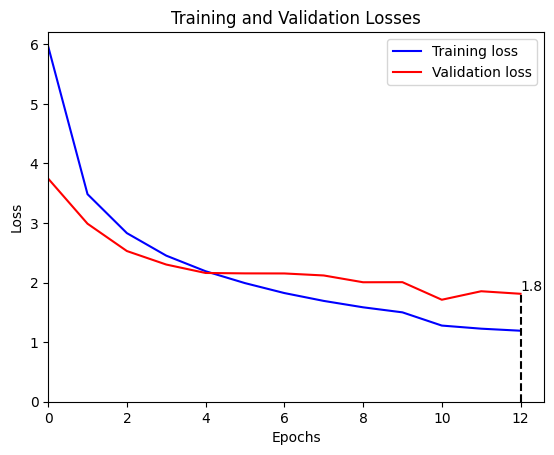

Traing epoch: 13   avg loss is: 1.1641449742443322
Validation epoch: 13   avg validation loss is: 1.6720917075872421
Validating on epoch: 13 has accuracy: top1: 83.16 top5: 94.00


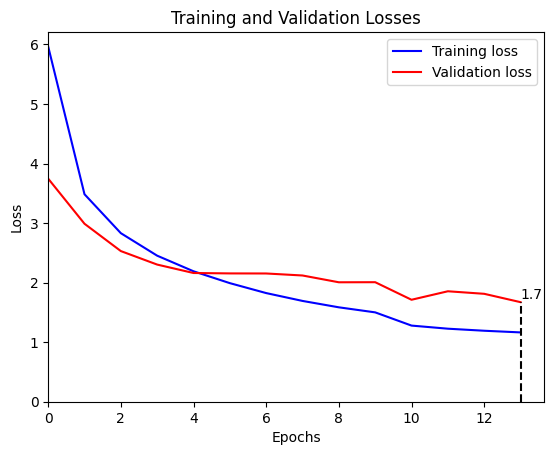

Traing epoch: 14   avg loss is: 1.1428132378756426
Validation epoch: 14   avg validation loss is: 1.6891246383127414
Validating on epoch: 14 has accuracy: top1: 82.79 top5: 93.63


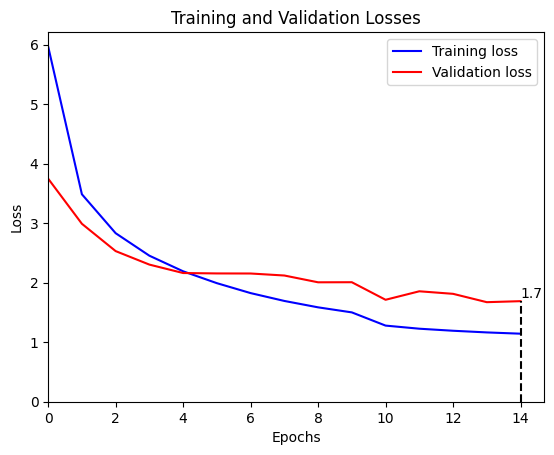

Traing epoch: 15   avg loss is: 1.1249088092784911
Validation epoch: 15   avg validation loss is: 1.7059098780155182
Validating on epoch: 15 has accuracy: top1: 82.83 top5: 94.08


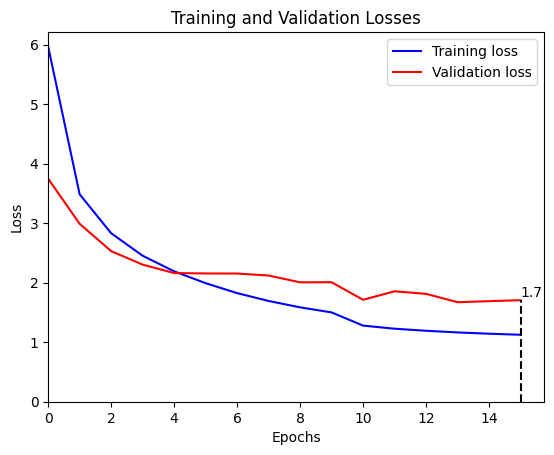

Traing epoch: 16   avg loss is: 1.1072500118087565
Validation epoch: 16   avg validation loss is: 1.7792761859140898
Validating on epoch: 16 has accuracy: top1: 79.77 top5: 91.81


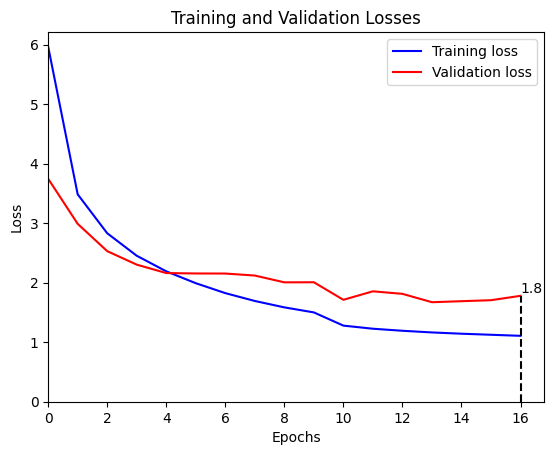

Traing epoch: 17   avg loss is: 1.0949139730966662
Validation epoch: 17   avg validation loss is: 1.682381576613376
Validating on epoch: 17 has accuracy: top1: 82.00 top5: 93.67


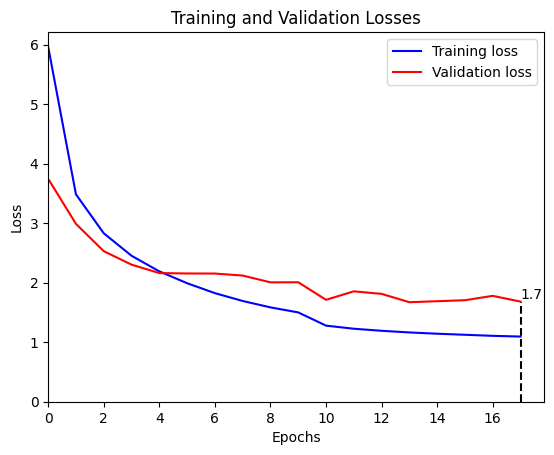

Traing epoch: 18   avg loss is: 1.0815085873417563
Validation epoch: 18   avg validation loss is: 1.7276105041566647
Validating on epoch: 18 has accuracy: top1: 81.09 top5: 93.17


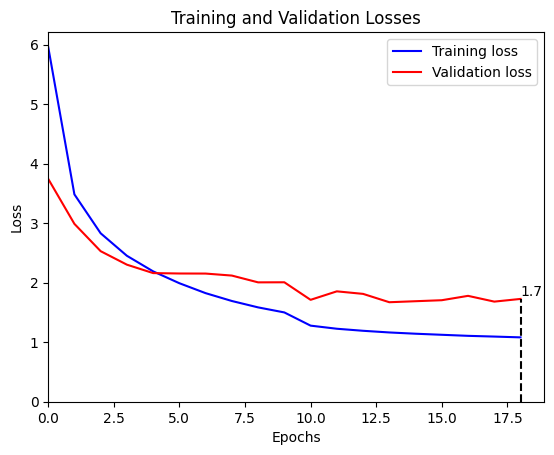

Traing epoch: 19   avg loss is: 1.070279024741052
Validation epoch: 19   avg validation loss is: 1.7283021572389101
Validating on epoch: 19 has accuracy: top1: 81.05 top5: 93.01


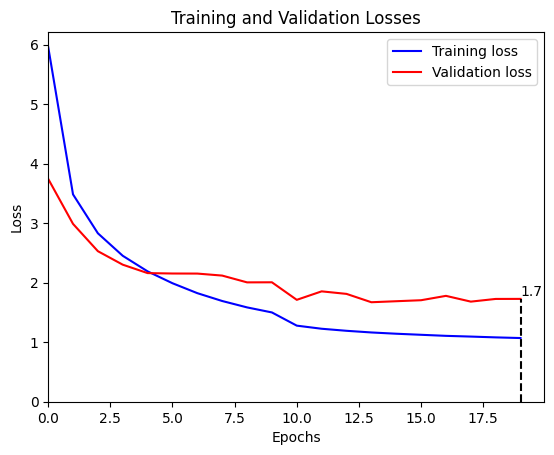

Traing epoch: 20   avg loss is: 1.0194249875722154
Validation epoch: 20   avg validation loss is: 1.6261025063301389
Validating on epoch: 20 has accuracy: top1: 85.35 top5: 94.29


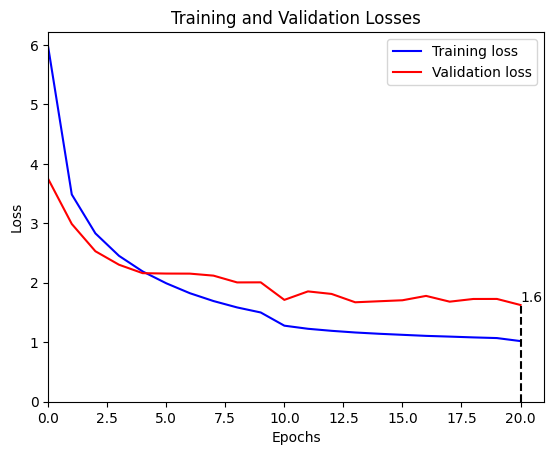

Traing epoch: 21   avg loss is: 1.007626845678362
Validation epoch: 21   avg validation loss is: 1.6644359403534938
Validating on epoch: 21 has accuracy: top1: 84.73 top5: 94.17


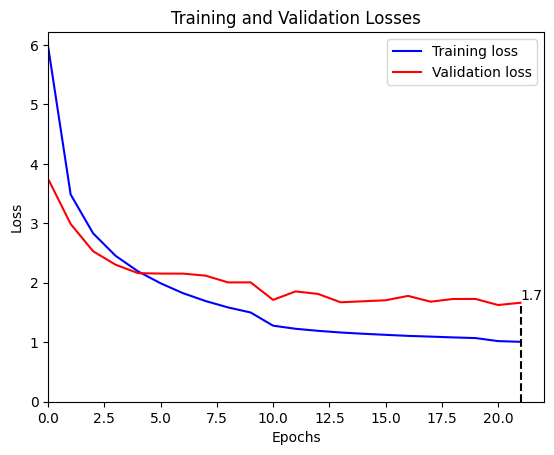

Traing epoch: 22   avg loss is: 1.0004691574928075
Validation epoch: 22   avg validation loss is: 1.6769230381438607
Validating on epoch: 22 has accuracy: top1: 83.66 top5: 94.50


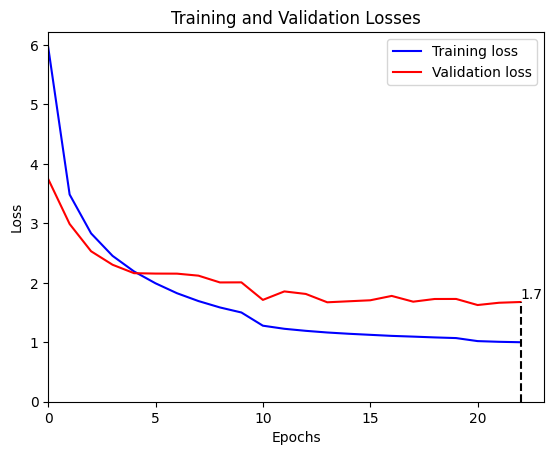

Traing epoch: 23   avg loss is: 0.9951832904709599
Validation epoch: 23   avg validation loss is: 1.6656083080329394
Validating on epoch: 23 has accuracy: top1: 83.95 top5: 93.84


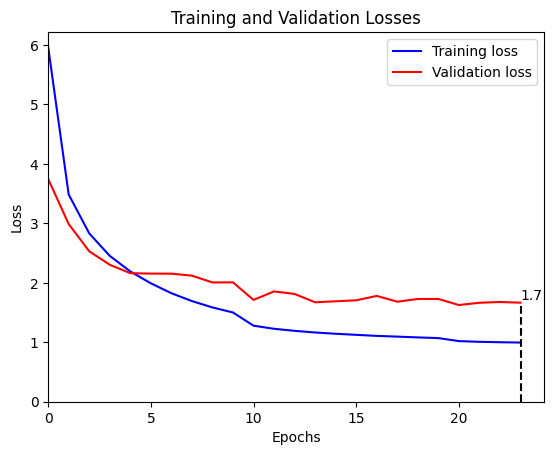

Traing epoch: 24   avg loss is: 0.9908334562940927
Validation epoch: 24   avg validation loss is: 1.65876331376402
Validating on epoch: 24 has accuracy: top1: 84.77 top5: 93.84


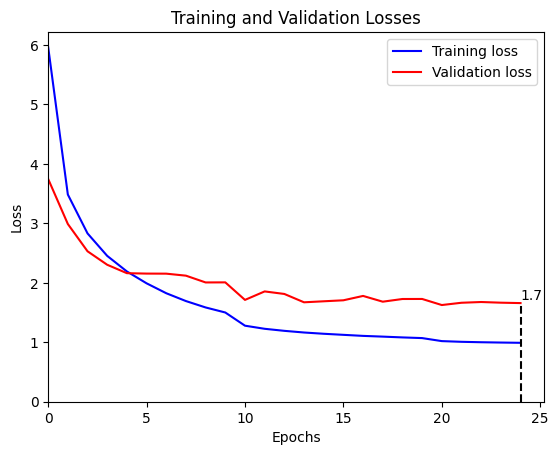

Traing epoch: 25   avg loss is: 0.9856009745810825
Validation epoch: 25   avg validation loss is: 1.6532215421137058
Validating on epoch: 25 has accuracy: top1: 84.98 top5: 93.88


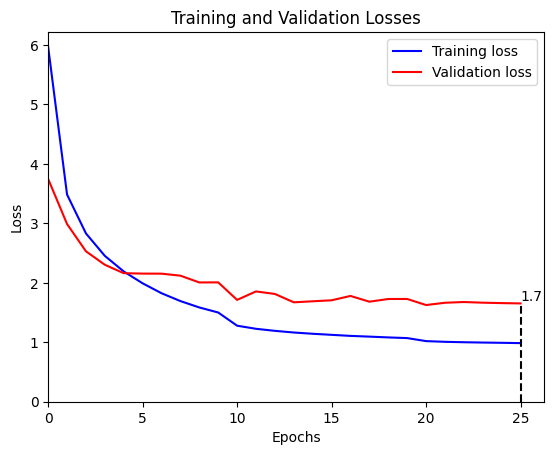

Traing epoch: 26   avg loss is: 0.982747265839038
Validation epoch: 26   avg validation loss is: 1.6573803095441115
Validating on epoch: 26 has accuracy: top1: 84.77 top5: 93.42


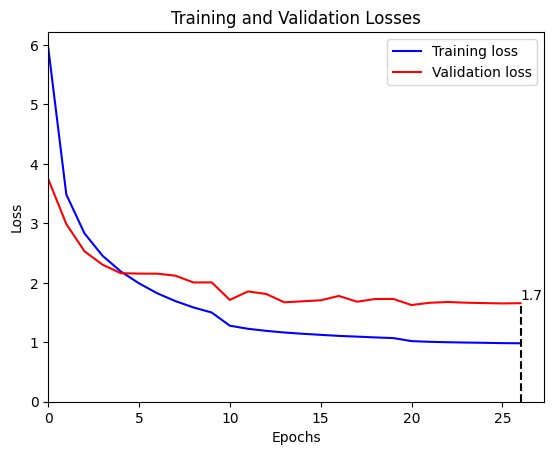

Traing epoch: 27   avg loss is: 0.9788816773049948
Validation epoch: 27   avg validation loss is: 1.669252675614859
Validating on epoch: 27 has accuracy: top1: 85.11 top5: 93.42


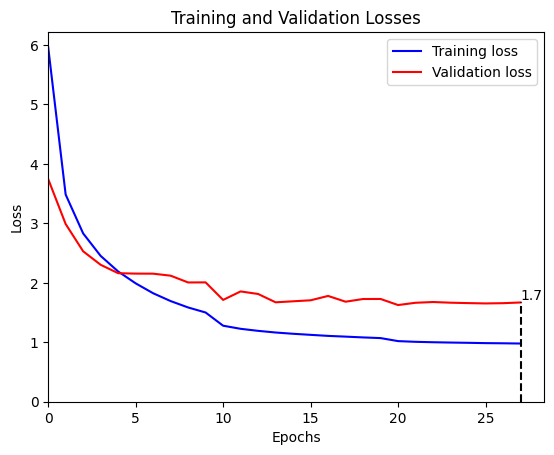

Traing epoch: 28   avg loss is: 0.9763970336222486
Validation epoch: 28   avg validation loss is: 1.779459680381574
Validating on epoch: 28 has accuracy: top1: 83.74 top5: 92.93


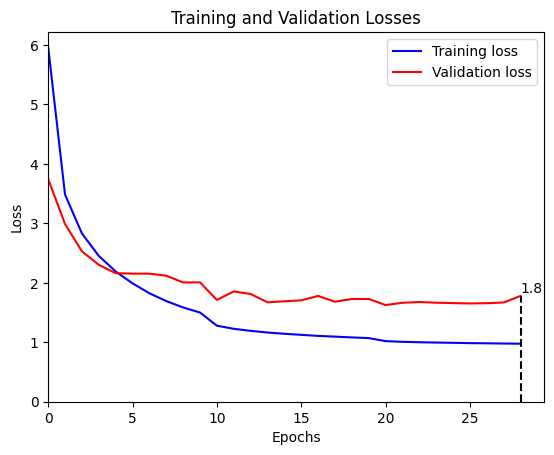

Traing epoch: 29   avg loss is: 0.9731796038904589
Validation epoch: 29   avg validation loss is: 1.634775619757803
Validating on epoch: 29 has accuracy: top1: 85.23 top5: 93.59


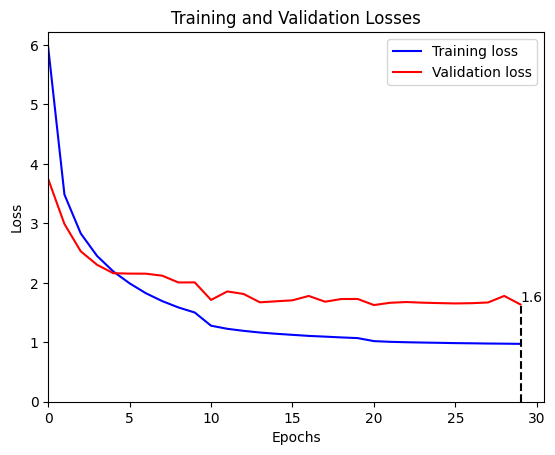

Traing epoch: 30   avg loss is: 0.9571721916817642
Validation epoch: 30   avg validation loss is: 1.6511725885303397
Validating on epoch: 30 has accuracy: top1: 85.77 top5: 93.88


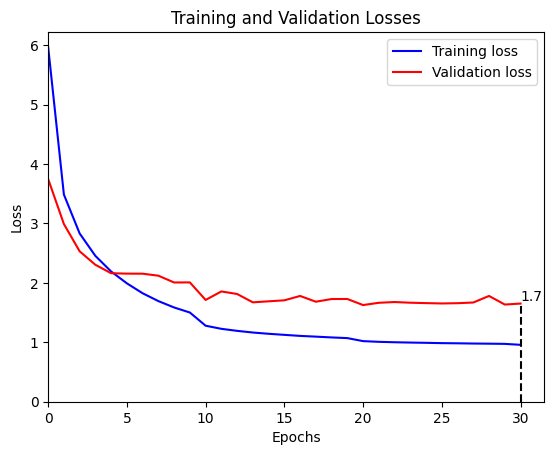

Traing epoch: 31   avg loss is: 0.9535051684263479
Validation epoch: 31   avg validation loss is: 1.6811944905080294
Validating on epoch: 31 has accuracy: top1: 85.93 top5: 93.96


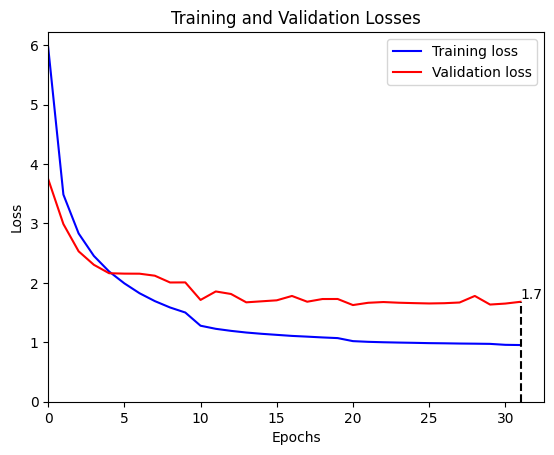

Traing epoch: 32   avg loss is: 0.9504515340228405
Validation epoch: 32   avg validation loss is: 1.6551284382217808
Validating on epoch: 32 has accuracy: top1: 85.81 top5: 93.79


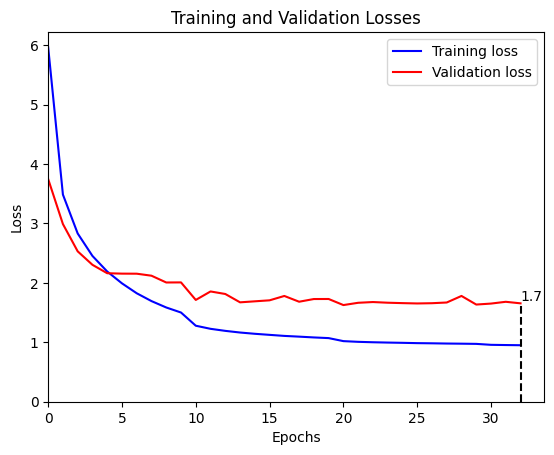

Traing epoch: 33   avg loss is: 0.9484922381620061
Validation epoch: 33   avg validation loss is: 1.6623536434612776
Validating on epoch: 33 has accuracy: top1: 85.52 top5: 93.67


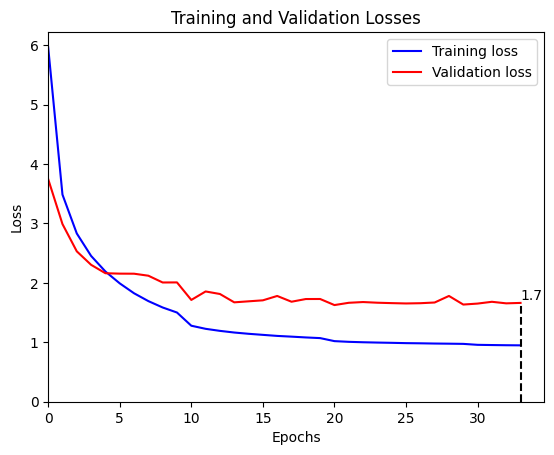

Traing epoch: 34   avg loss is: 0.9468592884641204
Validation epoch: 34   avg validation loss is: 1.679341921680852
Validating on epoch: 34 has accuracy: top1: 85.64 top5: 93.75


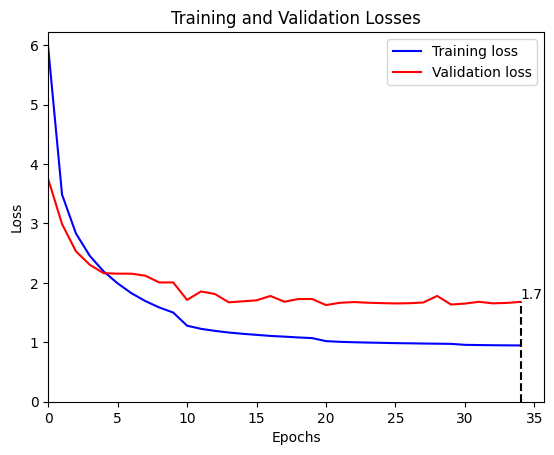

Traing epoch: 35   avg loss is: 0.9454713247561125
Validation epoch: 35   avg validation loss is: 1.6728945978377994
Validating on epoch: 35 has accuracy: top1: 85.11 top5: 93.59


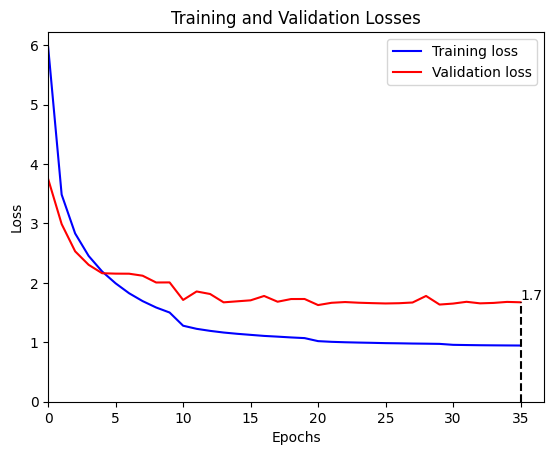

Traing epoch: 36   avg loss is: 0.9440293356340348
Validation epoch: 36   avg validation loss is: 1.6576142303253476
Validating on epoch: 36 has accuracy: top1: 85.93 top5: 93.92


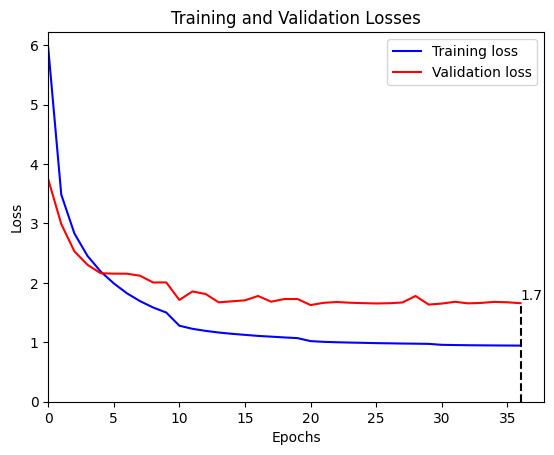

Traing epoch: 37   avg loss is: 0.9428124652578735
Validation epoch: 37   avg validation loss is: 1.6671376934176998
Validating on epoch: 37 has accuracy: top1: 85.89 top5: 93.75


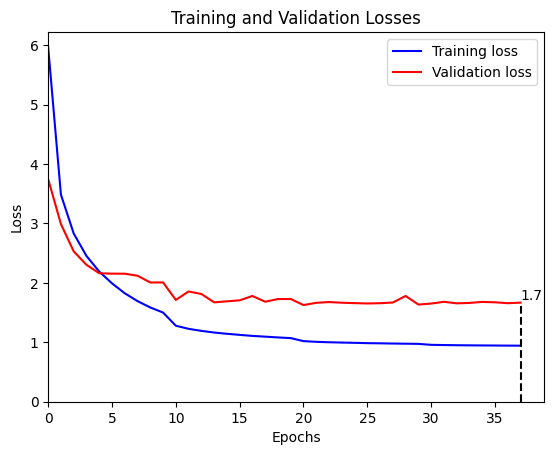

Traing epoch: 38   avg loss is: 0.9416364529521646
Validation epoch: 38   avg validation loss is: 1.6601869612932205
Validating on epoch: 38 has accuracy: top1: 85.73 top5: 93.88


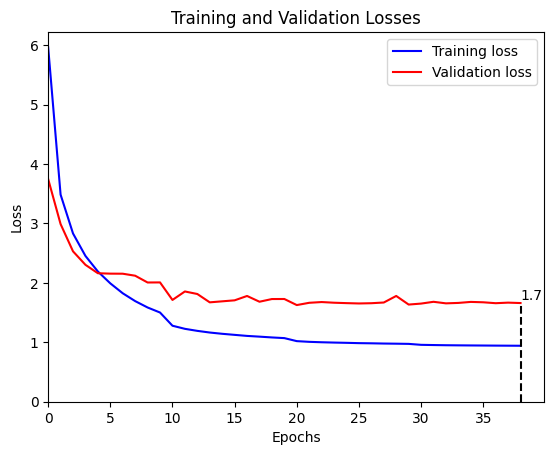

Traing epoch: 39   avg loss is: 0.9403932851194855
Validation epoch: 39   avg validation loss is: 1.6913490914984752
Validating on epoch: 39 has accuracy: top1: 85.52 top5: 93.59


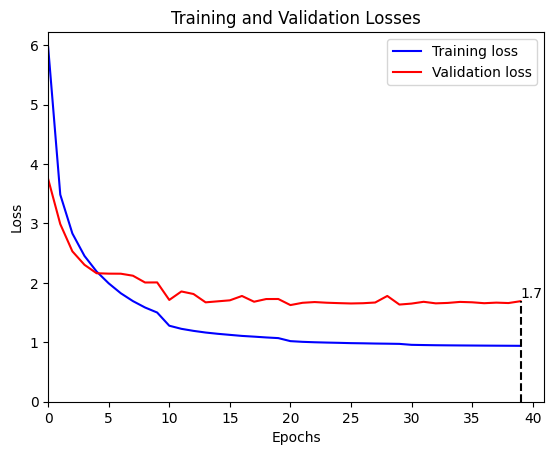

Traing epoch: 40   avg loss is: 0.9344270630566872
Validation epoch: 40   avg validation loss is: 1.6786327503229443
Validating on epoch: 40 has accuracy: top1: 85.85 top5: 93.79


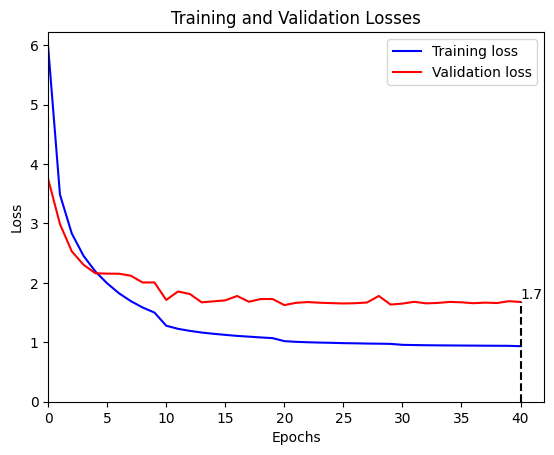

Traing epoch: 41   avg loss is: 0.9327499397708481
Validation epoch: 41   avg validation loss is: 1.6825158517611654
Validating on epoch: 41 has accuracy: top1: 85.93 top5: 94.17


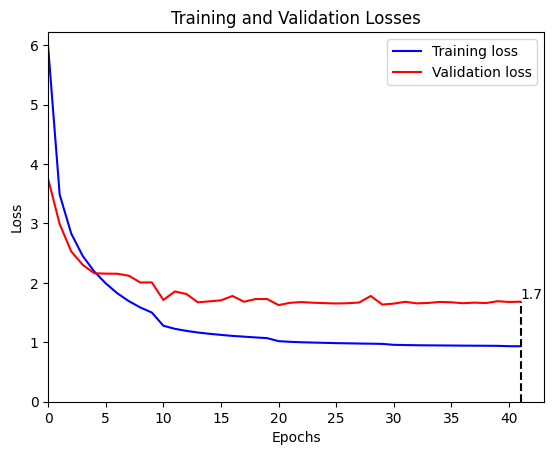

Traing epoch: 42   avg loss is: 0.9317617544173192
Validation epoch: 42   avg validation loss is: 1.6771005525400764
Validating on epoch: 42 has accuracy: top1: 86.06 top5: 93.67


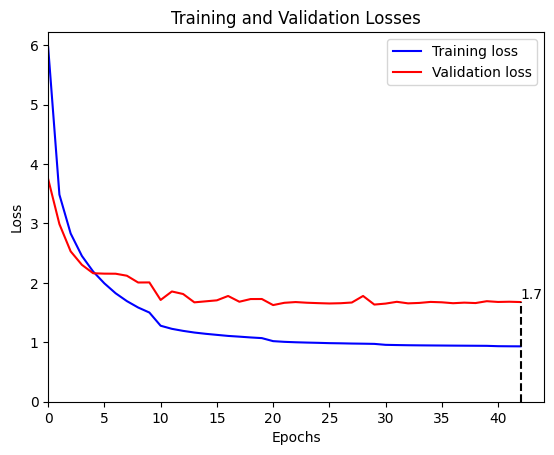

Traing epoch: 43   avg loss is: 0.9308877980297722
Validation epoch: 43   avg validation loss is: 1.6619906441161507
Validating on epoch: 43 has accuracy: top1: 85.81 top5: 93.75


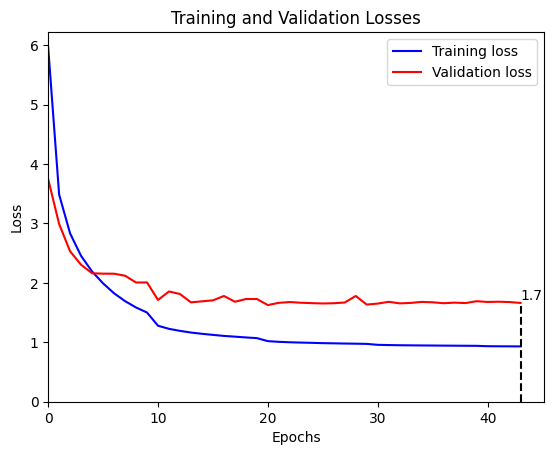

Traing epoch: 44   avg loss is: 0.9302375036919674
Validation epoch: 44   avg validation loss is: 1.6687575029699426
Validating on epoch: 44 has accuracy: top1: 86.14 top5: 93.63


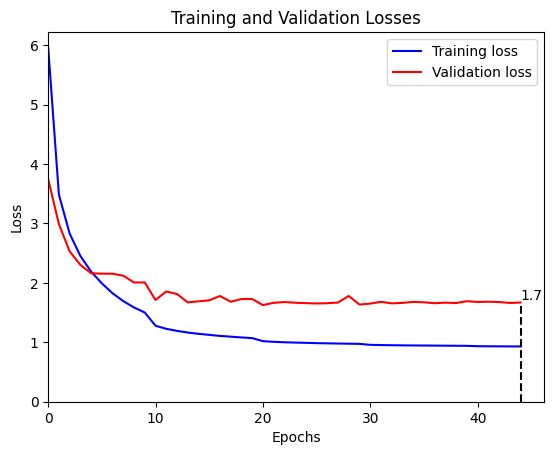

Traing epoch: 45   avg loss is: 0.9296049657647257
Validation epoch: 45   avg validation loss is: 1.7173418645796024
Validating on epoch: 45 has accuracy: top1: 86.31 top5: 93.75


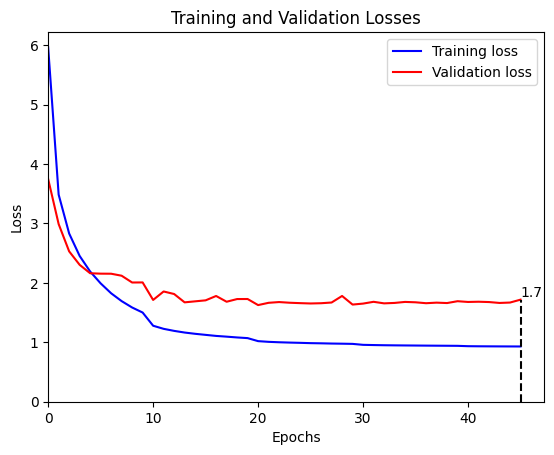

Traing epoch: 46   avg loss is: 0.9289530295376853
Validation epoch: 46   avg validation loss is: 1.6809715385499753
Validating on epoch: 46 has accuracy: top1: 86.10 top5: 93.84


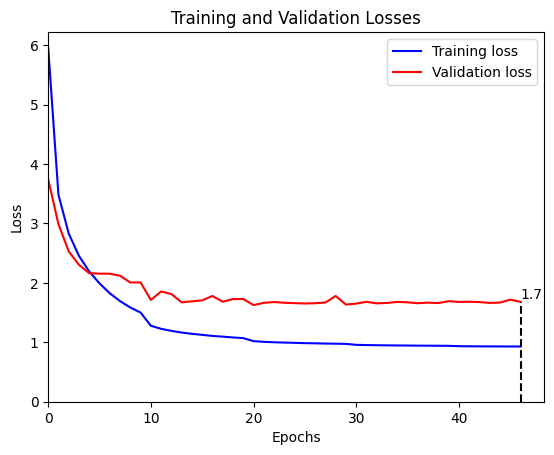

Traing epoch: 47   avg loss is: 0.9284346825000304
Validation epoch: 47   avg validation loss is: 1.692383913617385
Validating on epoch: 47 has accuracy: top1: 85.60 top5: 93.63


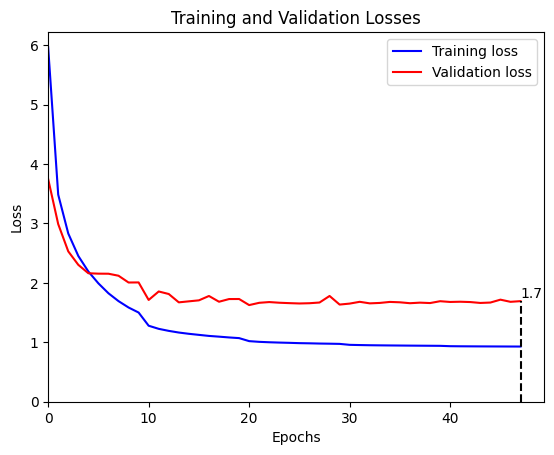

Traing epoch: 48   avg loss is: 0.9277166882064928
Validation epoch: 48   avg validation loss is: 1.7014804960865724
Validating on epoch: 48 has accuracy: top1: 85.40 top5: 93.75


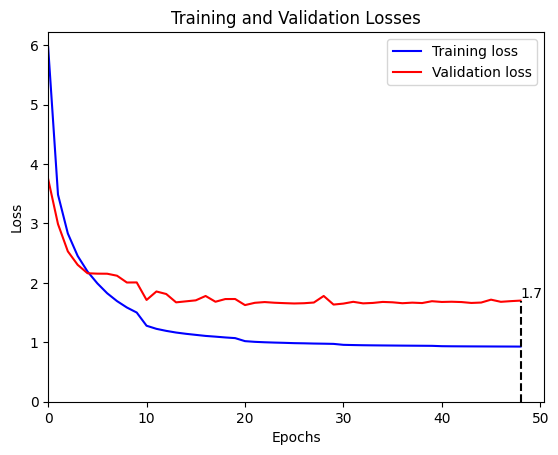

Traing epoch: 49   avg loss is: 0.9272228367881153
Validation epoch: 49   avg validation loss is: 1.695110924934086
Validating on epoch: 49 has accuracy: top1: 86.10 top5: 93.59


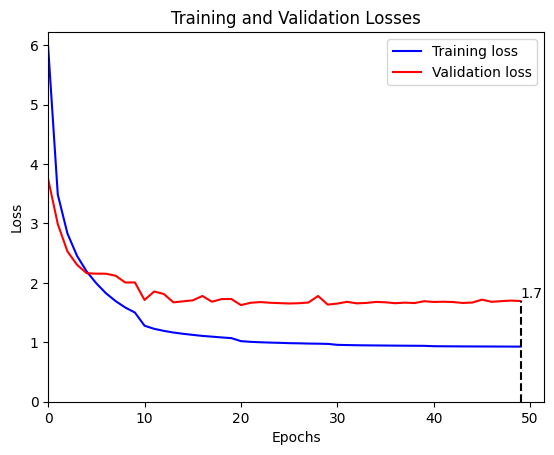

Traing epoch: 50   avg loss is: 0.9247410229948361
Validation epoch: 50   avg validation loss is: 1.688299030849808
Validating on epoch: 50 has accuracy: top1: 86.26 top5: 93.55


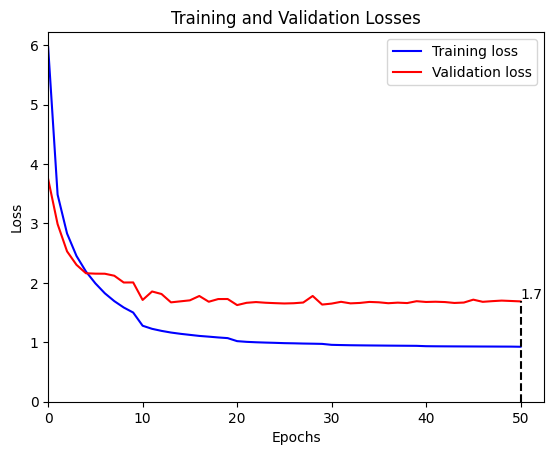

Traing epoch: 51   avg loss is: 0.9240508958407596
Validation epoch: 51   avg validation loss is: 1.6849538346654491
Validating on epoch: 51 has accuracy: top1: 86.39 top5: 93.75


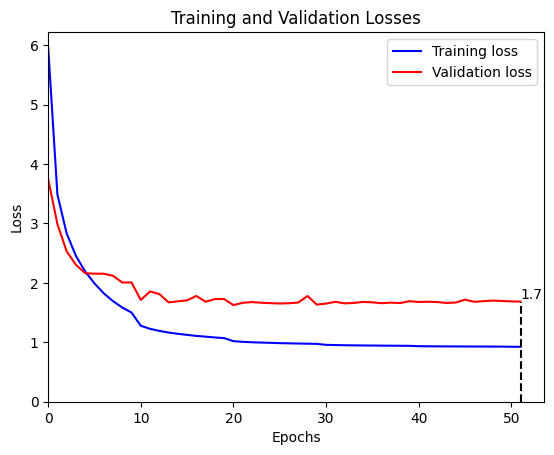

Traing epoch: 52   avg loss is: 0.9235689324325345
Validation epoch: 52   avg validation loss is: 1.7545625230199413
Validating on epoch: 52 has accuracy: top1: 85.19 top5: 93.79


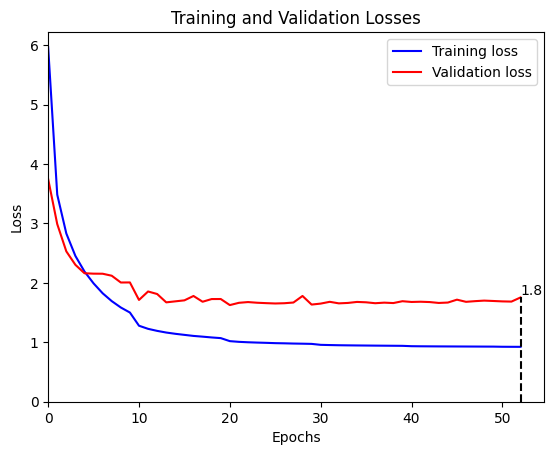

Traing epoch: 53   avg loss is: 0.9230731163682234
Validation epoch: 53   avg validation loss is: 1.6935018771573116
Validating on epoch: 53 has accuracy: top1: 86.02 top5: 93.71


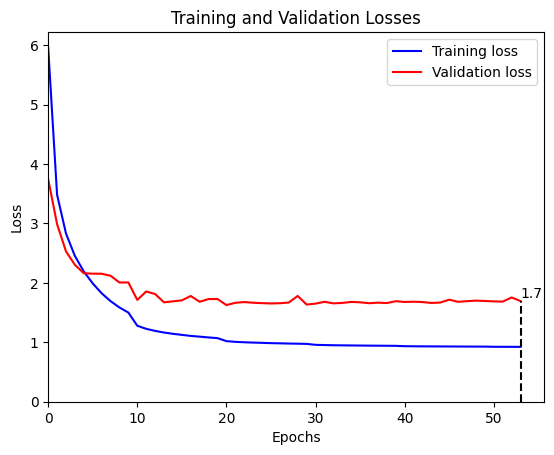

Traing epoch: 54   avg loss is: 0.9228580909887031
Validation epoch: 54   avg validation loss is: 1.7102047785332328
Validating on epoch: 54 has accuracy: top1: 85.89 top5: 93.67


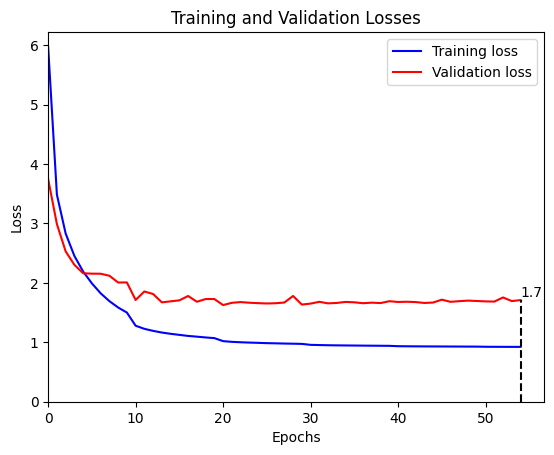

Traing epoch: 55   avg loss is: 0.9224168767985873
Validation epoch: 55   avg validation loss is: 1.7365630371005911
Validating on epoch: 55 has accuracy: top1: 85.73 top5: 93.88


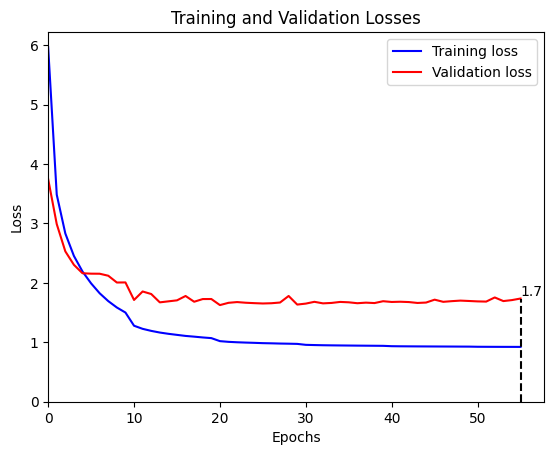

Traing epoch: 56   avg loss is: 0.9221914714513215
Validation epoch: 56   avg validation loss is: 1.6965276167580956
Validating on epoch: 56 has accuracy: top1: 86.22 top5: 93.59


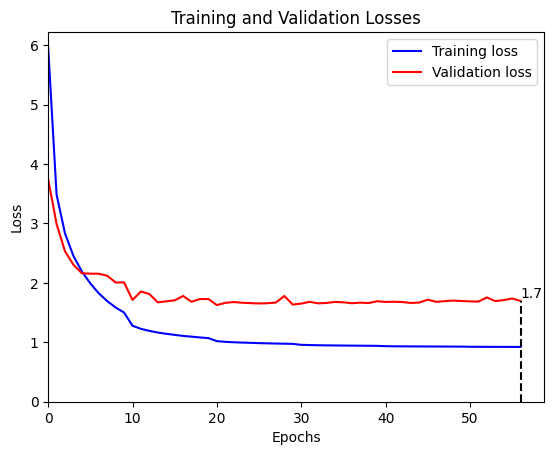

Traing epoch: 57   avg loss is: 0.9217934459787176
Validation epoch: 57   avg validation loss is: 1.7175462073401402
Validating on epoch: 57 has accuracy: top1: 86.02 top5: 93.71


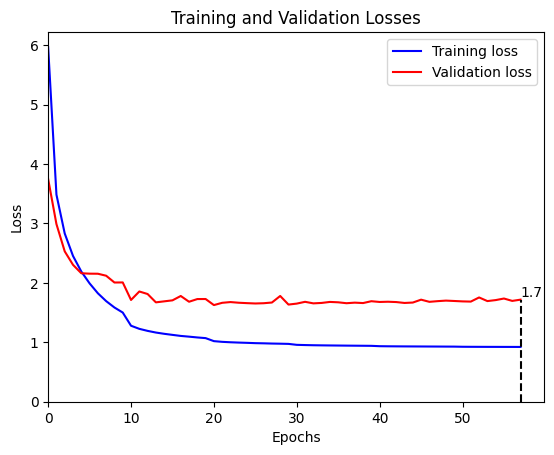

Traing epoch: 58   avg loss is: 0.9215697561468839
Validation epoch: 58   avg validation loss is: 1.7056907321277417
Validating on epoch: 58 has accuracy: top1: 86.43 top5: 93.67


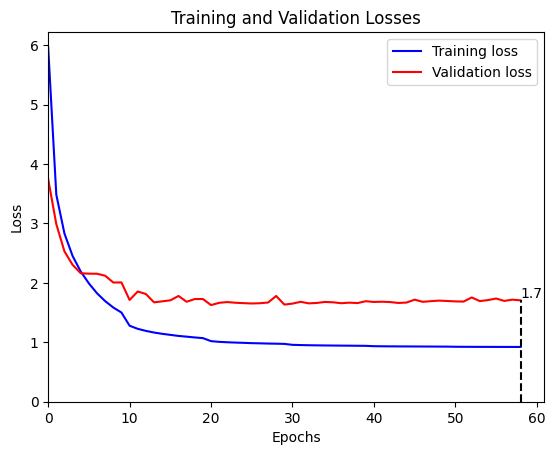

Traing epoch: 59   avg loss is: 0.9212747205575391
Validation epoch: 59   avg validation loss is: 1.7076631376617832
Validating on epoch: 59 has accuracy: top1: 86.43 top5: 93.84


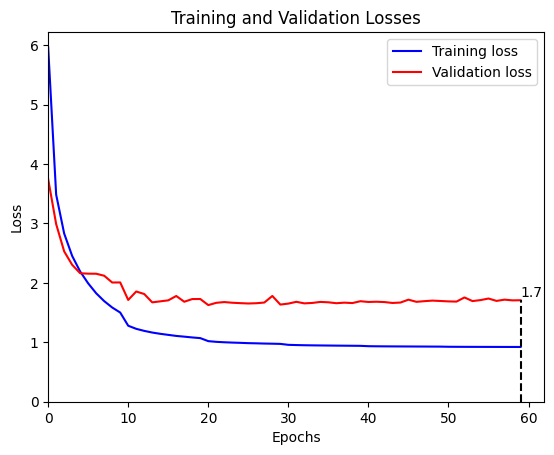

Traing epoch: 60   avg loss is: 0.9200998815205578
Validation epoch: 60   avg validation loss is: 1.7034208343217248
Validating on epoch: 60 has accuracy: top1: 86.10 top5: 93.75


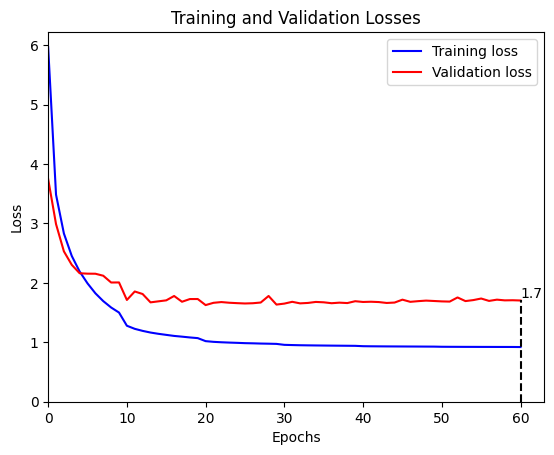

Traing epoch: 61   avg loss is: 0.9198260147468412
Validation epoch: 61   avg validation loss is: 1.7025816087660037
Validating on epoch: 61 has accuracy: top1: 85.97 top5: 93.67


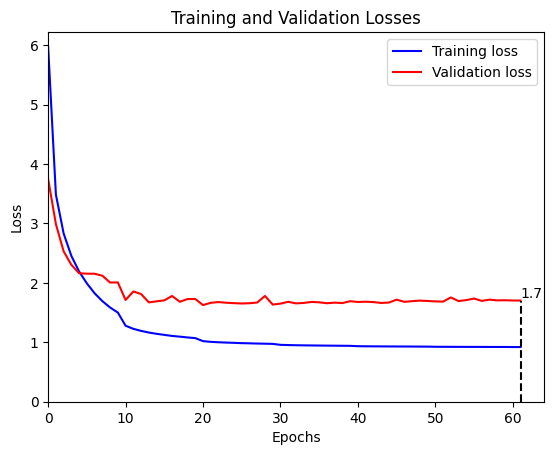

Traing epoch: 62   avg loss is: 0.919783113236226
Validation epoch: 62   avg validation loss is: 1.7004009359761287
Validating on epoch: 62 has accuracy: top1: 86.47 top5: 93.71


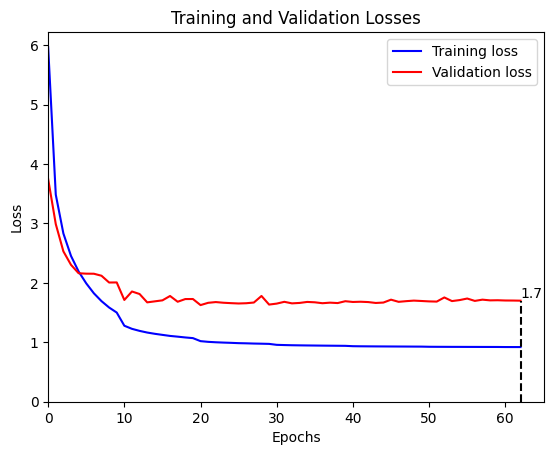

Traing epoch: 63   avg loss is: 0.9194852979551954
Validation epoch: 63   avg validation loss is: 1.6997343999774832
Validating on epoch: 63 has accuracy: top1: 86.51 top5: 93.79


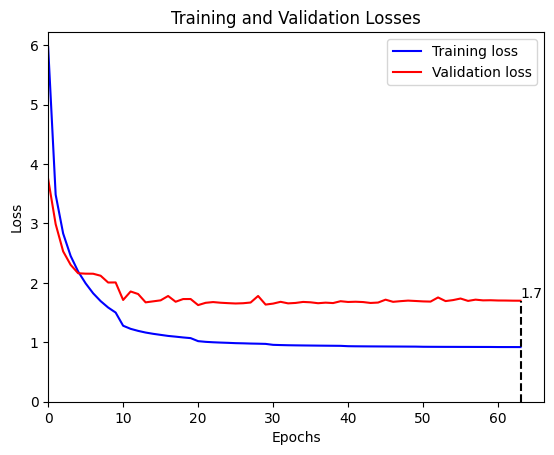

Traing epoch: 64   avg loss is: 0.9194125544692865
Validation epoch: 64   avg validation loss is: 1.7105309304438139
Validating on epoch: 64 has accuracy: top1: 86.59 top5: 93.84


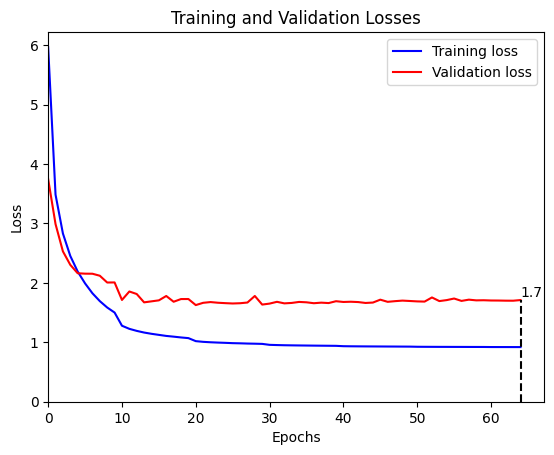

Traing epoch: 65   avg loss is: 0.9190646162758067
Validation epoch: 65   avg validation loss is: 1.7377927703292746
Validating on epoch: 65 has accuracy: top1: 86.10 top5: 93.84


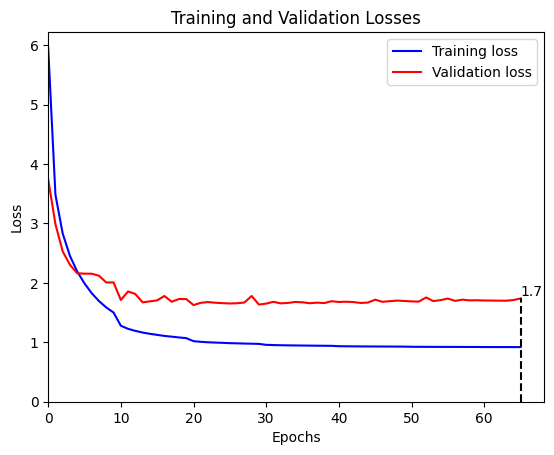

Traing epoch: 66   avg loss is: 0.9190557427008738
Validation epoch: 66   avg validation loss is: 1.7003936508768482
Validating on epoch: 66 has accuracy: top1: 86.76 top5: 93.71


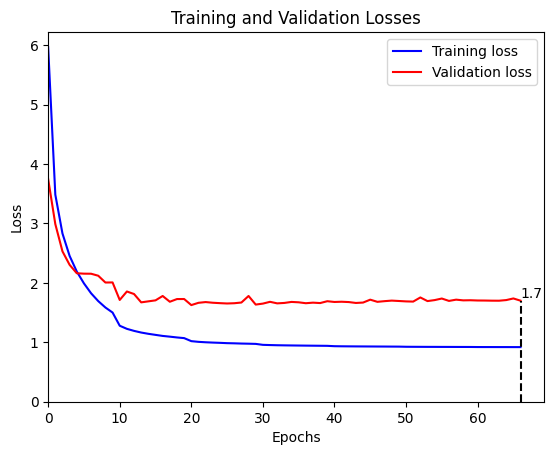

Traing epoch: 67   avg loss is: 0.9188828001529328
Validation epoch: 67   avg validation loss is: 1.7159038225286884
Validating on epoch: 67 has accuracy: top1: 86.31 top5: 93.63


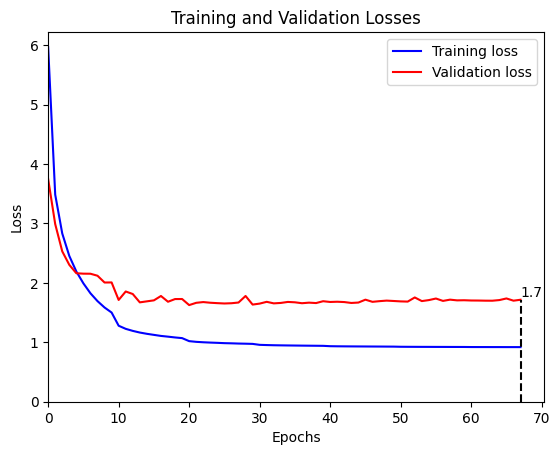

Traing epoch: 68   avg loss is: 0.9187377776358754
Validation epoch: 68   avg validation loss is: 1.7190984644387897
Validating on epoch: 68 has accuracy: top1: 86.31 top5: 93.71


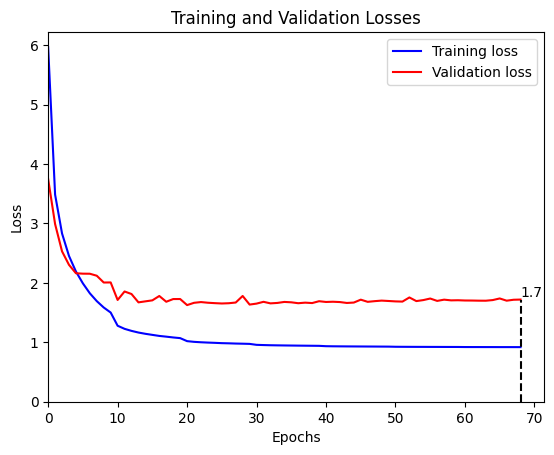

Traing epoch: 69   avg loss is: 0.9185660003488213
Validation epoch: 69   avg validation loss is: 1.7160980411266025
Validating on epoch: 69 has accuracy: top1: 86.22 top5: 93.96


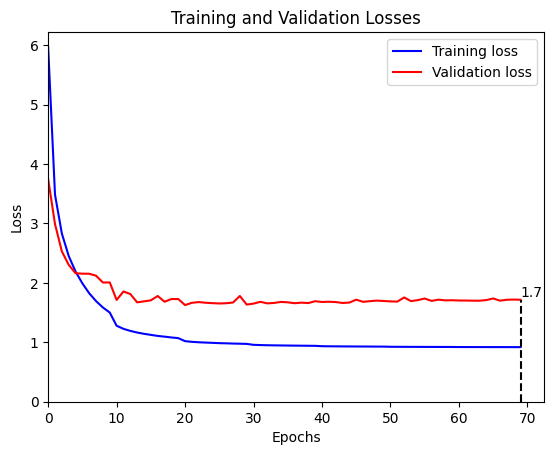

In [4]:
class DeepWriter_Train:
    def __init__(self,dataset='CERUG-EN',imgtype='png'):

        self.dataset = dataset
        self.folder = dataset
        #self.labelfolder = 'dataset/'

        if not os.path.exists(self.folder):
            if dataset == 'CERUG-EN':
                download_cerug(dataset)
            elif dataset == 'Firemaker':
                download_firemaker(dataset)
            else:
                print('****** Warning: the dataset %s does not existed!******'%dataset)
                print('Please go to the following website to check how to download the dataset:')
                print('https://www.ai.rug.nl/~sheng/writeridataset.html')
                print('*'*20)
                raise ValueError('Dataset: %s does not existed!'%dataset)

        self.labelfolder = self.folder
        
        source_folder = '/kaggle/input/firemaker-words/Firemaker Dataset/train/'
        destination_folder = '/kaggle/working/train/'
        
        copy_folder_contents(source_folder, destination_folder)
        
        
        #self.train_folder = self.folder+'/train/'
        self.train_folder = destination_folder

        transformer = ImageTransformer(foldername=self.train_folder)
        transformer.process_and_save_images()

        self.test_folder = '/kaggle/input/firemaker-words/Firemaker Dataset/test/'

        self.imgtype=imgtype
        self.device = 'cuda'
        self.scale_size=(64,128)

        if self.device == 'cuda':
            torch.backends.cudnn.benchmark = True

        if self.dataset == 'CVL':
            self.imgtype = 'tif'

        self.model_dir = 'model'
        if not os.path.exists(self.model_dir):
            #raise ValueError('Model directory: %s does not existed'%self.model_dir)
            os.mkdir(self.model_dir)#raise ValueError('Model directory: %s does not existed'%self.model_dir)

        #basedir = 'GRRNN_WriterIdentification_dataset_'+self.dataset+'_model_'+self.mode+'_aug_16'
        basedir = 'CTE_WriterIdentification_dataset_IAMCDAR_model_'
        self.logfile= basedir + '.log'
        self.modelfile = basedir
        self.batch_size = 16

        train_set = DatasetFromFolder(dataset=self.dataset,
        				labelfolder = self.labelfolder,
                        foldername=self.train_folder,
                        imgtype=self.imgtype,
                        scale_size=self.scale_size,
                        is_training = True)

        self.training_data_loader = DataLoader(dataset=train_set, num_workers=2,
                           batch_size=self.batch_size, shuffle=True, drop_last=True)

        test_set = DatasetFromFolder(dataset=self.dataset,
        				labelfolder = self.labelfolder,
                        foldername=self.test_folder,imgtype=self.imgtype,
                        scale_size=self.scale_size,
                        is_training = False)

        self.testing_data_loader = DataLoader(dataset=test_set, num_workers=2,
                           batch_size=self.batch_size, shuffle=False)

        num_class = train_set.num_writer
        self.model = GrnnNet(1,num_classes=train_set.num_writer).to(self.device)

        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = LabelSomCE()
        self.optimizer = optim.Adam(self.model.parameters(),lr=0.0001,weight_decay=1e-4)
        self.scheduler = lr_scheduler.StepLR(self.optimizer,step_size=10,gamma=0.5)


    def train(self,epoch):
        self.model.train()
        losstotal = []

        for iteration,batch in enumerate(self.training_data_loader,1):
            inputs = batch[0].to(self.device).float()
            target = batch[1].type(torch.long).to(self.device)

            self.optimizer.zero_grad()

            logits = self.model(inputs)

            train_loss= self.criterion(logits,target)

            losstotal.append(train_loss.item())
            train_loss.backward()
            self.optimizer.step()

        with open(self.logfile,'a') as fp:
            fp.write('Training epoch %d avg loss is: %.6f\n'%(epoch,np.mean(losstotal)))
        print('Traing epoch:',epoch,'  avg loss is:',np.mean(losstotal))


        return np.mean(losstotal)


    def test(self,epoch,during_train=True):
        self.model.eval()
        losstotal = []

        if not during_train:
            self.load_model(epoch)

        top1 = 0
        top5 = 0
        ntotal=0
        
        #all_preds = []
        #all_targets = []

        for iteration,batch in enumerate(self.testing_data_loader,1):
            inputs = batch[0].to(self.device).float()
            target = batch[1].to(self.device).long()

            logits = self.model(inputs)

            test_loss = self.criterion(logits,target)

            losstotal.append(test_loss.item())

            res = self.accuracy(logits,target,topk=(1,5))
            top1 += res[0]
            top5 += res[1]

            ntotal += inputs.size(0)
            
            #_, preds = logits.topk(1, 1, True, True)
            #all_preds.extend(preds.cpu().numpy().flatten())
            #all_targets.extend(target.cpu().numpy().flatten())



        top1 /= float(ntotal)
        top5 /= float(ntotal)
        
        #precision, recall, f1 = self.compute_metrics(all_preds, all_targets)

        print('Validation epoch:',epoch,'  avg validation loss is:',np.mean(losstotal))
        print('Validating on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
        #print('Precision: %.2f%%, Recall: %.2f%%, F1 Score: %.2f%%' % (precision * 100, recall * 100, f1 * 100))
        with open(self.logfile,'a') as fp:
            fp.write('Validating epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))

        return np.mean(losstotal)



    def check_exists(self,epoch):
        model_out_path = self.model_dir + '/' + self.modelfile + '-model_epoch_{}.pth'.format(epoch)
        return os.path.exists(model_out_path)

    def checkpoint(self,epoch):
        model_out_path = self.model_dir + '/' + self.modelfile + '-model_epoch_{}.pth'.format(epoch)
        torch.save(self.model.state_dict(),model_out_path)


    def load_model(self,epoch):
        model_out_path = self.model_dir + '/' + self.modelfile + '-model_epoch_{}.pth'.format(epoch)
        self.model.load_state_dict(torch.load(model_out_path,map_location=self.device))
        print('Load model successful')

    def plot_losses(self, training_losses, testing_losses):
        indices = range(len(training_losses))
        plt.plot(indices, training_losses, 'b', label='Training loss')
        plt.plot(indices, testing_losses, 'r', label='Validation loss')
        #
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.xlim(left=0)
        plt.ylim(bottom=0)

        last_epoch = indices[-1]
        last_test_loss = testing_losses[-1]
        plt.plot([last_epoch, last_epoch], [0, last_test_loss], 'k--')
        plt.text(last_epoch, last_test_loss, f'{last_test_loss:.1f}', color='k', va='bottom', ha='left')
        plt.savefig("/kaggle/working/loss_plot.svg", format="svg", dpi=300)
        
        plt.title('Training and Validation Losses')

        plt.show()

    def train_loops(self,start_epoch,num_epoch):
        #if self.check_exists(num_epoch): return
        if start_epoch > 0:
            self.load_model(start_epoch-1)

        training_losses = []
        testing_losses = []

        for epoch in range(start_epoch,num_epoch):
            train_loss = self.train(epoch)
            training_losses.append(train_loss)
            self.checkpoint(epoch)
            test_loss = self.test(epoch)
            testing_losses.append(test_loss)
            self.scheduler.step()
            self.plot_losses(training_losses, testing_losses)


    def accuracy(self,output,target,topk=(1,)):
        with torch.no_grad():
            maxk = max(topk)
            _,pred = output.topk(maxk,1,True,True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            res = []
            for k in topk:
                correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
                res.append(correct_k.data.cpu().numpy())

        return res
    
    
    #def compute_metrics(self, preds, targets):
     #   precision, recall, f1, _ = precision_recall_fscore_support(targets, preds, average='macro')
      #  return precision, recall, f1





if __name__ == '__main__':


    mod = DeepWriter_Train(dataset='/kaggle/input/firemaker-words/Firemaker Dataset')
    mod.train_loops(0,70)